In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import six
import tensorflow as tf

from edward.inferences import VariationalInference
from edward.models import Bernoulli, Normal, RandomVariable
from edward.util import copy
from scipy.special import expit

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline

ed.set_seed(42)

import pylab
pylab.rcParams['figure.figsize'] = (16.0, 10.0)

In [2]:
# use custom helper functions from src folder
import sys
sys.path.insert(0, '../src/')

from data import *
from inference import *
from helpers import *

### DATA

In [3]:
# for this basic example, lets only examine a small subset of the data

N = 1000  # number of data points
D = 5  # number of features
X_data, y_data, X_test, y_test = get_dataset(N=N,D=D)
print('shapes (X,y),', X_data.shape, y_data.shape)

shapes (X,y), (1000, 5) (1000,)


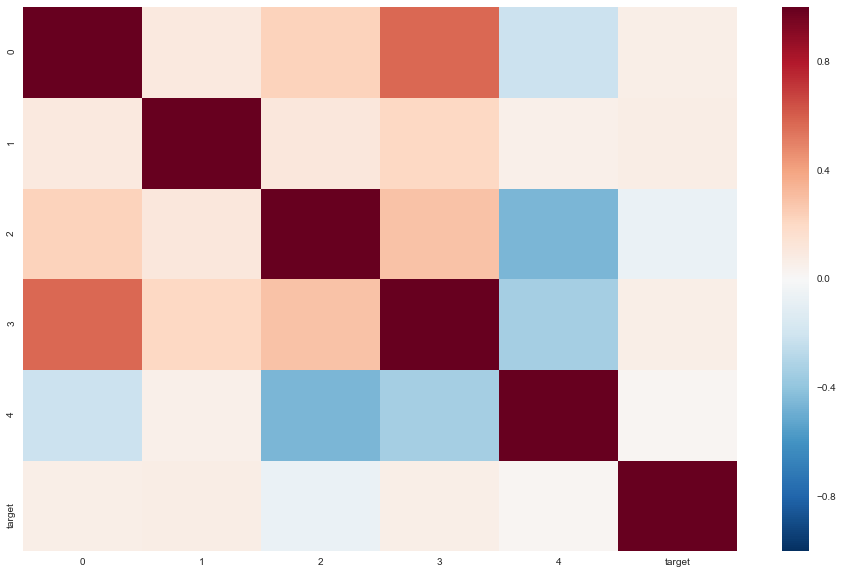

In [4]:
df = pd.DataFrame(X_data)
df['target'] = y_data
sns.heatmap(df.corr());
# title='correlation of features and binary target'

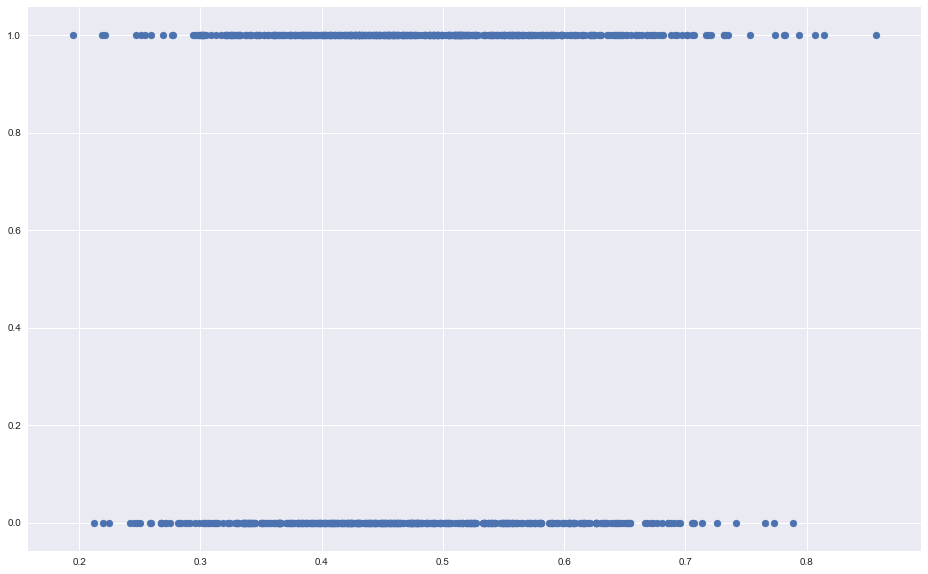

In [5]:
plt.scatter(X_data[:,0], y_data)

In [6]:
M = 128    # batch size during training
y_ph = tf.placeholder(tf.int32, [None])
data = generator([X_data, y_data], M)    

### MODEL

In [7]:
X = tf.placeholder(tf.float32, [None , D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Bernoulli(logits=(ed.dot(X, w)+b))

### INFERENCE

In [8]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Helper functions to maximize the Evidence Lower bound (moved "log" outside compared to standard VAE)

$$ log(p(x)) >= -E_{q(z^1; \lambda), ..., q(z^K; \lambda)} [ \log \frac{1}{K} \sum_{k=1}^K \frac{p(x, z^k)}{q(z^k; \lambda)} ]$$

In [9]:
# inference = IWVI({w: qw,  b: qb}, data={X: X_data, y: y_data})
# inference.run(K=5, n_iter=10000, n_print=1)

alternatively, we use KLqp for batch learning

In [10]:
N = len(X_data)
n_batch = int(N / M)
n_epoch = 5

inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
inference.initialize(n_iter=n_batch * n_epoch, n_samples=5, scale={y: N / M})
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
  X_batch, y_batch = next(data)
  info_dict = inference.update({X: X_batch, y_ph: y_batch})
  inference.print_progress(info_dict)

### CRITICISM

In [11]:
y_post = ed.copy(y, {w: qw, b:qb})

#### todo: implemention of edward's logloss metric is buggy as it accepts predictions instead of logits
#### I've raised an issue here: https://github.com/blei-lab/edward/issues/795

In [12]:
for sam,Xx,yy in [("INS", X_data, y_data), ("OOS",X_test, y_test)]:
    print(sam)
    print("binary_acc:", ed.evaluate('binary_accuracy', data={X: Xx, y_post: yy}))
    print("binary_cross_entropy:", ed.evaluate('log_loss', data={X: Xx, y_post: yy}))  # todo bug in implementation

INS
binary_acc: 0.507
binary_cross_entropy: 0.744288
OOS
binary_acc: 0.459
binary_cross_entropy: 0.76645


In [13]:
print("log_loss:", ed.evaluate('log_loss', data={X: X_data, y_post: y_data})) # todo bug in implementation
print("categorical_crossentropy:", ed.evaluate('categorical_crossentropy', data={X: X_data, y_post: y_data}))
print("log_likelihood:", ed.evaluate('log_likelihood', data={X: X_data, y_post: y_data}))

log_loss: 0.759417
categorical_crossentropy: 3555.81
log_likelihood: -0.716666


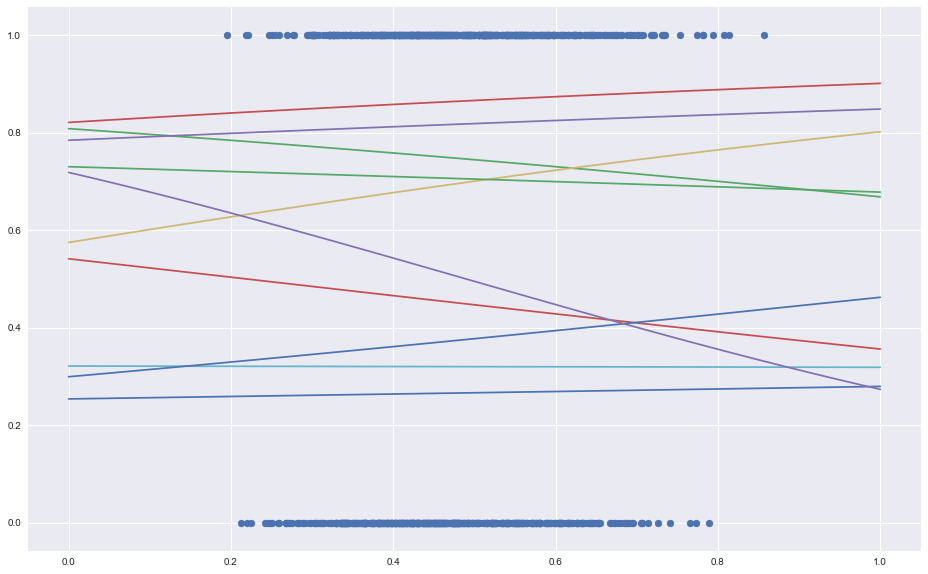

In [14]:
ww = visualise(X_data, y_data, w, b) #prior samples

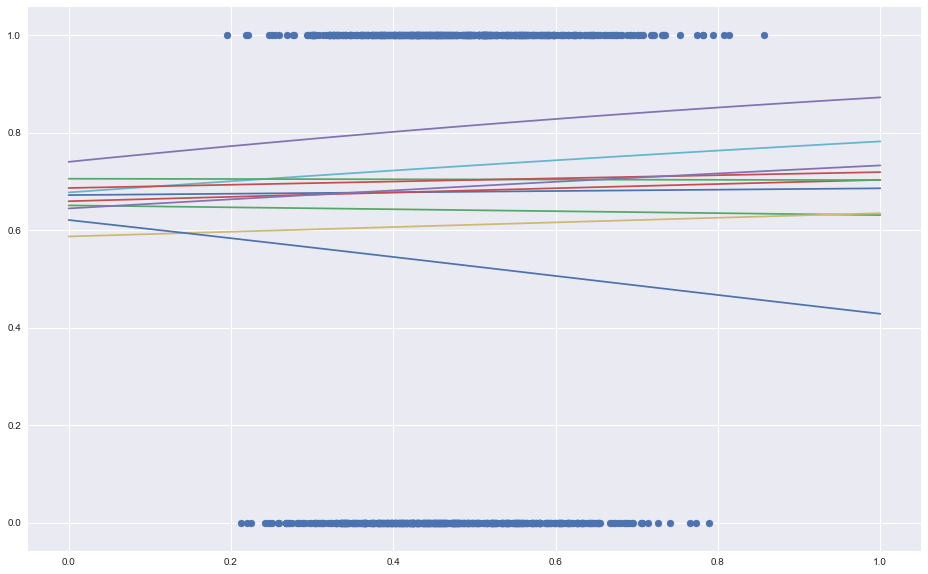

In [15]:
ww = visualise(X_data, y_data, qw, qb) #posterior samples

In [16]:
def binary_crossentropy(y_true, y_pred):
  """Binary cross-entropy.
  Args:
    y_ue: tf.Tensor.
      Tensor of 0s and 1s.
    y_pred: tf.Tensor.
      Tensor of real values (logit probabilities), with same shape as
      `y_true`.
  """
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)
  return tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true))

In [17]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

def get_y_preds(X_data, y_data, w, b, n_samples=10):
    w_samples = [w.eval() for _ in range(n_samples)]
    b_samples = [b.eval() for _ in range(n_samples)]
    return w_samples, b_samples

def eval_model(Xx, Yy, nom):
    ans = get_y_preds(Xx, Yy, qw, qb, n_samples=10000)
    zw, zb = np.mean(ans[0], axis=0), np.mean(ans[1], axis=0)
    probabilities = sigmoid(Xx.dot(zw) + zb)
    #probabilities = probabilities.clip(.49,.51)
    ins = pd.DataFrame(probabilities)
    ins['target'] = Yy
    ins['guess'] = ins[0].round().clip(0,1)
    print(nom, '\n------')
    print('acc:', (ins['target'] == ins['guess']).mean())
    print('sk.logloss:', log_loss(ins['target'], ins[0]))
    sess = get_session()
    print('ed.logloss (corrected):', sess.run(binary_crossentropy(ins['target'], -np.log(1/ins[0] -1)   )   ))
    print('ed.logloss (current):', sess.run(binary_crossentropy(ins['target'], ins[0]   )   ))

    print ('')
    return ins

ins = eval_model(X_data, y_data, 'ins')
oos = eval_model(X_test, y_test, 'oos');

ins 
------
acc: 0.51
sk.logloss: 0.692930608598
ed.logloss (corrected): 0.692931
ed.logloss (current): 0.720129

oos 
------
acc: 0.456
sk.logloss: 0.703283688926
ed.logloss (corrected): 0.703284
ed.logloss (current): 0.734248



In [18]:
from edward.util import check_data, get_session
from sklearn.metrics import log_loss

preds = np.array([.5]*1000)
target = np.random.randint(0,2,1000)

print('acc:', (target == preds.round()).mean())
print('logloss:', log_loss(target, preds))
sess = get_session()
print('ed.logloss:', sess.run(binary_crossentropy(target, preds)))

x = preds
z = target
print('tf.doc.logloss', np.mean(x - x * z + np.log(1 + np.exp(-abs(x)))))

acc: 0.49
logloss: 0.69314718056
ed.logloss: 0.719076
tf.doc.logloss 0.71907698418


In [19]:
ins.describe()

,0,target,guess
count,1000.000000,1000.000000,1000.000000
mean,0.504992,0.508000,0.576000
std,0.035949,0.500186,0.494438
min,0.379169,0.000000,0.000000
25%,0.480614,0.000000,0.000000
50%,0.506326,1.000000,1.000000
75%,0.528520,1.000000,1.000000
max,0.631339,1.000000,1.000000


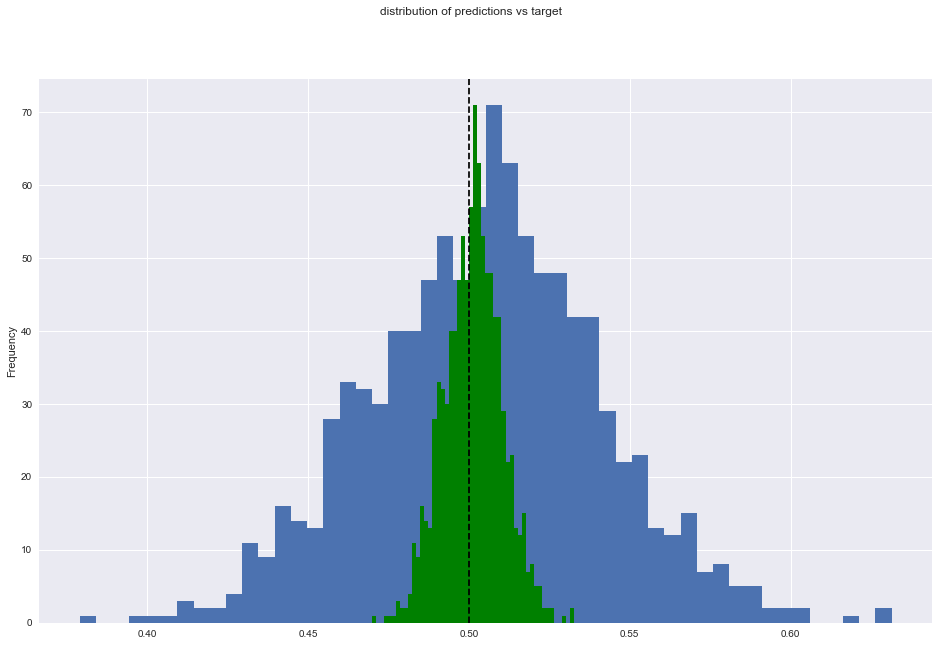

In [20]:
ax = ins[0].plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of predictions vs target', bins=50)
ax[0].axvline(.5, color='k', linestyle='--')
#ins['target'].plot(kind='hist', ax=ax[0], color='red', bins=50)

(((ins[0]-.5)*.25)+.5).plot(kind='hist', ax=ax[0], color='green', bins=50) # strinkage around 50%?

In [36]:
ed.ppc(lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)), data={x_post: X_data})

[array([ 0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.50505728,  0.50505728,
         0.50505728,  0.50505728,  0.50505728,  0.5

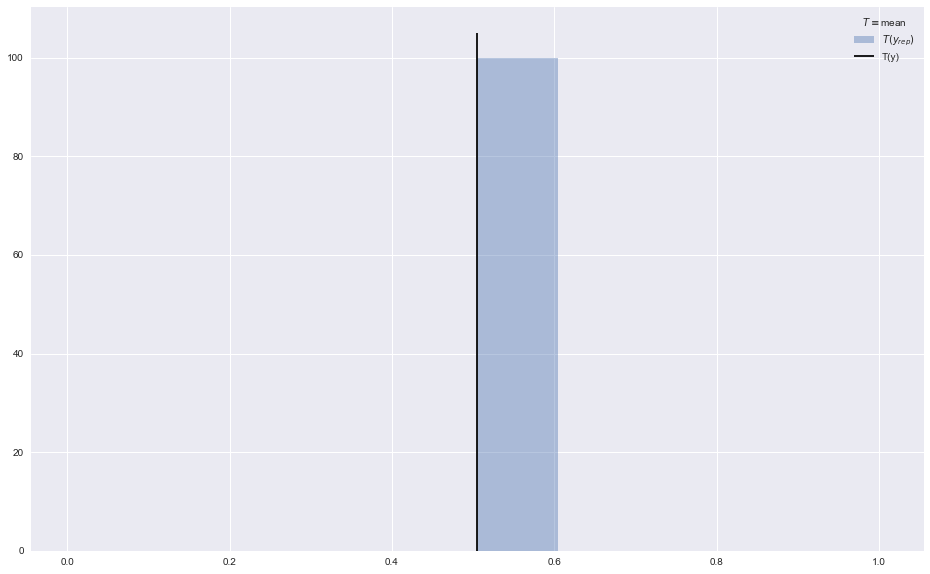

In [21]:
x_post = ed.copy(X, {w: qw, b: qb})
y_rep, y = ed.ppc(
    lambda xs, zs: tf.reduce_mean(tf.cast(xs[x_post], tf.float32)),
    data={x_post: X_data})

ed.ppc_stat_hist_plot(
    y[0], y_rep, stat_name=r'$T \equiv$mean', bins=10)
plt.show()

In [22]:
def T(xs, zs):
    return tf.reduce_max(xs[y_post])

ppc_max = ed.ppc(T, data={X: X_data, y_post: y_data})

In [23]:
qb.sample(50000).eval()

array([[ 0.71304309],
       [ 0.7945289 ],
       [ 0.56492364],
       ..., 
       [ 0.55708712],
       [ 0.88012064],
       [ 1.06034696]], dtype=float32)

In [24]:
## correlation with target is approxmently mean of posterior distribution on parameter

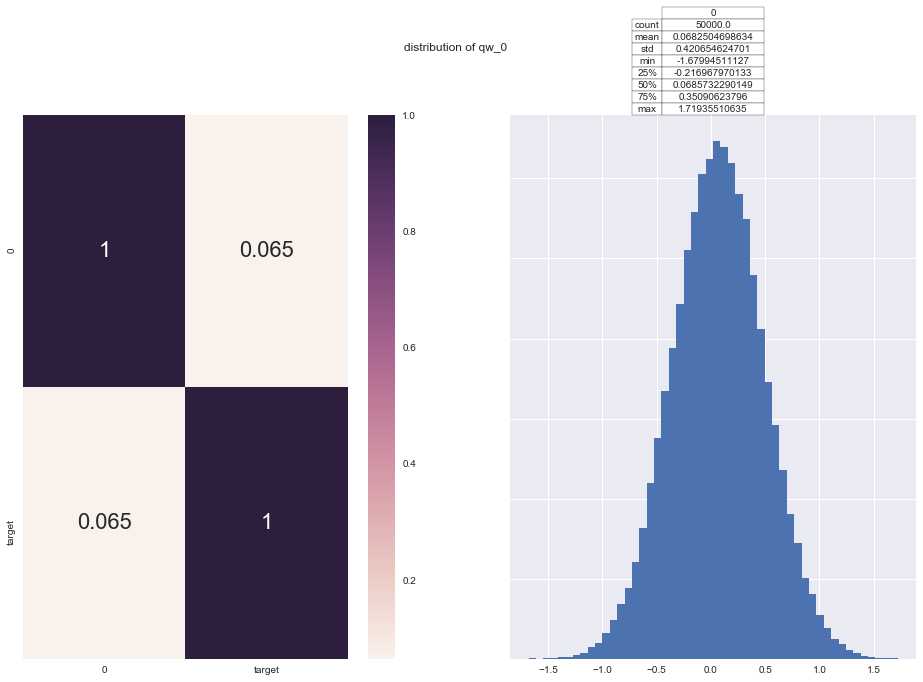

In [25]:
fig, axs = plt.subplots(1,2)


df = pd.DataFrame(X_data[:,0])
df['target'] = y_data
sns.heatmap(df.corr(), annot=True, ax=axs[0], annot_kws={'size':22})
dc = pd.Series(qw.sample(50000).eval()[:,0])
ax = dc.plot(kind='hist',subplots=True,sharex=False,sharey=True,title='distribution of qw_0', bins=50, ax=axs[1])

dcsummary = pd.DataFrame(dc.describe())
plt.table(cellText=dcsummary.values,colWidths = [0.25]*len(dcsummary.columns),
          rowLabels=dcsummary.index,
          colLabels=dcsummary.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top');

In [26]:
dcsummary

,0
count,50000.000000
mean,0.068250
std,0.420655
min,-1.679945
25%,-0.216968
50%,0.068573
75%,0.350906
max,1.719355


In [27]:
## ppc is 1 since y_data.mean() > 1?

In [28]:
y_data.mean()

0.50800000000000001

In [29]:
ppc_max

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)]